# Bird Classification with Tensorflow on Amazon SageMaker - Directly in your notebook

1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Train the model](#Train-the-model)
4. [Test the model](#Test-the-model)

## Introduction

Image classification is the process of predicting which of several classes is represented by a particular image. This is useful across a wide variety of use cases from manufacturing quality control to medical diagnosis. To create an image classification solution, we need to acquire and process a training dataset, and train a model from that dataset. The trained model is then capable of identifying features and predicting which class an image belongs to. Finally, we can make predictions using the trained model against previously unseen images.

This notebook is an end-to-end example showing how to build an image classifier using TensorFlow and Keras, simply using
Amazon SageMaker's hosted Jupyter notebook directly. This is an easy transition from traditional model development you may already be doing on your laptop or on a separate Amazon EC2 instance. Subsequent notebooks will demonstrate how to take full advantage of SageMaker's training service, hosting service, and automatic model tuning. Note that for complex large scale machine learning models, training directly in a notebook can be cost prohibitive.

For each of these labs, we use a publicly available dataset of bird images based on the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. We demonstrate transfer learning by leveraging pretrained ImageNet weights for a MobileNet V2 network architecture.

For a quick demonstration, you can pick a small handful of bird species (set `SAMPLE_ONLY = True` and choose a few classes). For a more complete model, you can train against all 200 bird species in the dataset.

## Data Preparation

The [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found [here](http://www.vision.caltech.edu/visipedia/papers/CUB_200_2011.pdf)).  Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels.  Bounding boxes are provided, as are annotations of bird parts.  A recommended train/test split is given, but image size data is not.

![](./cub_200_2011_snapshot.png)

The dataset can be downloaded [here](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).

### Download and unpack the dataset

Here we download the birds dataset from CalTech. You can do this once and keep the unpacked dataset in your notebook instance.

In [2]:
import os 
import urllib.request

def download(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [3]:
%%time
download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')

CPU times: user 1.61 s, sys: 2.62 s, total: 4.23 s
Wall time: 1min 15s


In [4]:
%%time
# Clean up prior version of the downloaded dataset if you are running this again
!rm -rf CUB_200_2011  

# Unpack and then remove the downloaded compressed tar file
!gunzip -c ./CUB_200_2011.tgz | tar xopf - 
!rm CUB_200_2011.tgz

CPU times: user 73 ms, sys: 6.65 ms, total: 79.6 ms
Wall time: 6.87 s


### Set some parameters for the rest of the notebook to use
Here we define a few parameters that help drive the rest of the notebook.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting `SAMPLE_ONLY` to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need to tune parameters and run more epochs.

An `EXCLUDE_IMAGE_LIST` is defined as a mechanism to address any corrupt images from the dataset and ensure they do not disrupt the process.

In [5]:
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
SAMPLE_ONLY  = True
CLASSES = [13, 17] #, 35, 36, 47, 68, 73, 87]

# Otherwise, you can use the full set of species
if (not SAMPLE_ONLY):
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

BASE_DIR   = 'CUB_200_2011/'
IMAGES_DIR = BASE_DIR + 'images/'

CLASSES_FILE = BASE_DIR + 'classes.txt'
IMAGE_FILE   = BASE_DIR + 'images.txt'
LABEL_FILE   = BASE_DIR + 'image_class_labels.txt'

SPLIT_RATIOS = (0.7, 0.2, 0.1)

CLASS_COLS      = ['class_number','class_id']

EXCLUDE_IMAGE_LIST = ['087.Mallard/Mallard_0130_76836.jpg']

## Understand the dataset
Show the list of bird species or dataset classes.

In [6]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]

class_name_list = sorted(classes_df['class_id'].unique().tolist())
print(class_name_list)

['013.Bobolink', '017.Cardinal']


For each species, there are dozens of images of various shapes and sizes. By dividing the entire dataset into individual named (numbered) folders, the images are in effect labelled for supervised learning using image classification and object detection algorithms. 

The following function displays a grid of thumbnail images for all the image files for a given species.

In [7]:
def show_species(species_id):
    _im_list = !ls $IMAGES_DIR/$species_id

    NUM_COLS = 4
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(12.0, 20.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()       
    plt.show()
        
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

Species 013.Bobolink has 60 images.


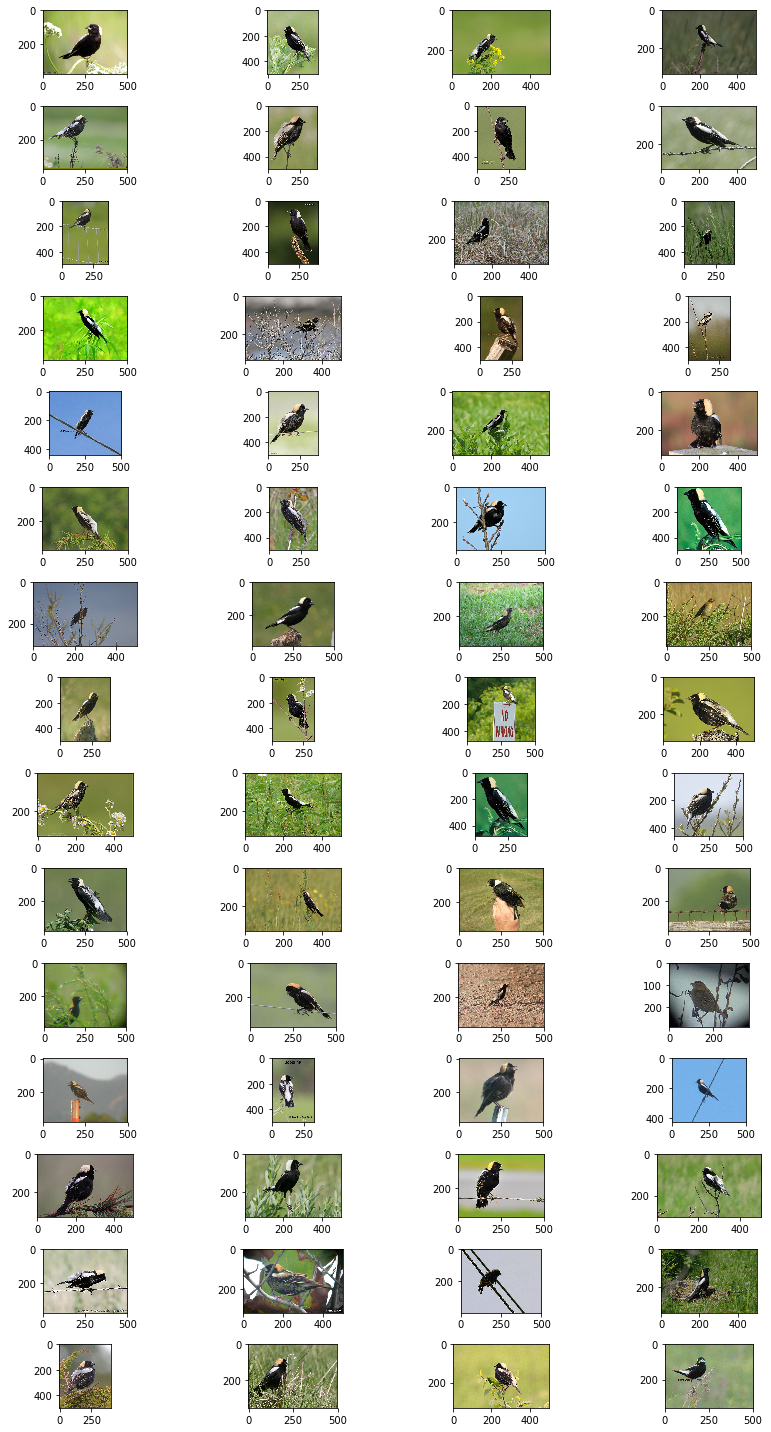

In [8]:
show_species('013.Bobolink')

### Create train/val/test dataframes from our dataset
Here we split our dataset into training, testing, and validation datasets, each in their own Pandas dataframe.

In [9]:
def split_to_train_val_test(df, label_column, splits=(0.7, 0.2, 0.1), verbose=False):
    train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]

        lbl_train_df        = lbl_df.sample(frac=splits[0])
        lbl_val_and_test_df = lbl_df.drop(lbl_train_df.index)
        lbl_test_df         = lbl_val_and_test_df.sample(frac=splits[2]/(splits[1] + splits[2]))
        lbl_val_df          = lbl_val_and_test_df.drop(lbl_test_df.index)

        if verbose:
            print('\n{}:\n---------\ntotal:{}\ntrain_df:{}\nval_df:{}\ntest_df:{}'.format(lbl,
                                                                        len(lbl_df), 
                                                                        len(lbl_train_df), 
                                                                        len(lbl_val_df), 
                                                                        len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        val_df   = val_df.append(lbl_val_df)
        test_df  = test_df.append(lbl_test_df)

    # shuffle them on the way out using .sample(frac=1)
    return train_df.sample(frac=1), val_df.sample(frac=1), test_df.sample(frac=1)

def get_train_val_dataframes():
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    image_class_labels_df = pd.read_csv(LABEL_FILE, sep=' ',
                                names=['image_pretty_name', 'orig_class_id'], header=None)

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df = full_df[~full_df.image_file_name.isin(EXCLUDE_IMAGE_LIST)]

    full_df.reset_index(inplace=True, drop=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['orig_class_id'].isin(CLASSES)
        full_df = full_df[criteria]
        print('Using subset of total images based on sample class list. subtotal: {}'.format(full_df.shape[0]))

    unique_classes = full_df['orig_class_id'].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)
    id_to_one_based = {}
    i = 1
    for c in sorted_unique_classes:
        id_to_one_based[c] = str(i)
        i += 1

    full_df['class_id'] = full_df['orig_class_id'].map(id_to_one_based)
    full_df.reset_index(inplace=True, drop=True)

    def get_class_name(fn):
        return fn.split('/')[0]
    full_df['class_name'] = full_df['image_file_name'].apply(get_class_name)
    full_df = full_df.drop(['image_pretty_name'], axis=1)

    train_df = []
    test_df  = []
    val_df   = []

    # split into training and validation sets
    train_df, val_df, test_df = split_to_train_val_test(full_df, 'class_id', SPLIT_RATIOS)

    print('num images total: ' + str(images_df.shape[0]))
    print('\nnum train: ' + str(train_df.shape[0]))
    print('num val: ' + str(val_df.shape[0]))
    print('num test: ' + str(test_df.shape[0]))
    return train_df, val_df, test_df

In [10]:
train_df, val_df, test_df = get_train_val_dataframes()

Using subset of total images based on sample class list. subtotal: 117
num images total: 11788

num train: 82
num val: 23
num test: 12


In [11]:
train_df.head()

,image_file_name,orig_class_id,class_id,class_name
70,017.Cardinal/Cardinal_0054_19334.jpg,17,2,017.Cardinal
49,013.Bobolink/Bobolink_0114_10627.jpg,13,1,013.Bobolink
55,013.Bobolink/Bobolink_0117_10215.jpg,13,1,013.Bobolink
79,017.Cardinal/Cardinal_0023_19026.jpg,17,2,017.Cardinal
72,017.Cardinal/Cardinal_0078_17181.jpg,17,2,017.Cardinal


## Train the model 
Here we train the model.

In [45]:
HEIGHT = 224
WIDTH  = 224
BATCH_SIZE = 16

In [46]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
LAST_FROZEN_LAYER = 20

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Prepare image data generators from our dataframes

In [47]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=60,
      brightness_range=(0.8, 1.0),
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=False
    )
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, directory=IMAGES_DIR,
                                              x_col='image_file_name', y_col='class_id',
                                              target_size=(HEIGHT, WIDTH), 
                                              batch_size=BATCH_SIZE)
val_gen = train_datagen.flow_from_dataframe(val_df, directory=IMAGES_DIR,
                                              x_col='image_file_name', y_col='class_id',
                                              target_size=(HEIGHT, WIDTH), 
                                              batch_size=BATCH_SIZE)
test_gen = train_datagen.flow_from_dataframe(test_df, directory=IMAGES_DIR,
                                              x_col='image_file_name', y_col='class_id',
                                              target_size=(HEIGHT, WIDTH), 
                                              batch_size=1,
                                              shuffle=False) # need predictable order for test

Found 82 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


### Define the model

In [48]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

In [49]:
base_model = MobileNetV2(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [102]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # Freeze all base layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        if (dropout != 0.0):
            x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax', name='output')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

# Here we extend the base model with additional fully connected layers, dropout for avoiding
# overfitting to the training dataset, and a classification layer
num_classes = len(class_name_list)
model = build_finetune_model(base_model, 
                              dropout=0.5, 
                              fc_layers=[1024], 
                              num_classes=num_classes)

### Perform training and save the model

In [104]:
from tensorflow.keras.optimizers import SGD, RMSprop

NUM_EPOCHS = 10
INITIAL_EPOCHS = 2
FINE_TUNING = True

num_train_images = len(train_gen.filepaths)
num_val_images   = len(val_gen.filepaths)

opt = RMSprop(lr=0.00001) # or Adam

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

if not FINE_TUNING:
    history = model.fit_generator(train_gen, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       validation_data=val_gen, validation_steps=num_val_images // BATCH_SIZE,
                                       shuffle=True)
else:
    model.fit_generator(train_gen, epochs=INITIAL_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       validation_data=val_gen, validation_steps=num_val_images // BATCH_SIZE,
                                       shuffle=True)
    
    for layer in model.layers[LAST_FROZEN_LAYER:]:
        layer.trainable = True
    
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit_generator(train_gen, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       validation_data=val_gen, validation_steps=num_val_images // BATCH_SIZE,
                                       shuffle=True)

Epoch 1/2
5/5 [==============================] - 19s 4s/step - loss: 0.6646 - acc: 0.6667 - val_loss: 0.2866 - val_acc: 0.8750
Epoch 2/2
5/5 [==============================] - 13s 3s/step - loss: 0.7801 - acc: 0.7576 - val_loss: 0.2258 - val_acc: 0.8750
Epoch 1/10
5/5 [==============================] - 36s 7s/step - loss: 0.2849 - acc: 0.9394 - val_loss: 0.0732 - val_acc: 0.9375
Epoch 2/10
5/5 [==============================] - 18s 4s/step - loss: 0.2687 - acc: 0.8750 - val_loss: 0.1778 - val_acc: 0.8750
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.1596 - acc: 0.9423 - val_loss: 0.2142 - val_acc: 0.9375
Epoch 4/10
5/5 [==============================] - 19s 4s/step - loss: 0.2281 - acc: 0.9250 - val_loss: 0.3045 - val_acc: 0.8750
Epoch 5/10
5/5 [==============================] - 17s 3s/step - loss: 0.1099 - acc: 0.9697 - val_loss: 0.4042 - val_acc: 0.9375
Epoch 6/10
5/5 [==============================] - 17s 3s/step - loss: 0.1167 - acc: 0.9545 - val_loss: 0.0

In [55]:
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
model.save('./checkpoints/' + 'MobileNetV2' + '_bird_model_weights.h5')

In [103]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [126]:
print('TF: {}'.format(tensorflow.__version__))
print('Keras: {}'.format(tf.keras.__version__))

TF: 1.14.0
Keras: 2.2.4-tf


In [120]:
!rm -rf ./checkpoints/*

In [121]:
!ls ./checkpoints

In [122]:
tf.contrib.saved_model.save_keras_model(model, './checkpoints').expect_partial()

W0907 22:42:04.869644 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer
W0907 22:42:04.870402 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-1._updates
W0907 22:42:04.870850 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-3._updates
W0907 22:42:04.871246 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-5._updates
W0907 22:42:04.871635 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-7._updates
W0907 22:42:04.871941 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-9._updates
W0907 22:42:04.872288 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-11._updates
W0907 22:42:04.872609 140689944135488 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-13._updates
W0907 22:42:04.872948 140689944135488 util.py:244]

W0907 22:42:04.893474 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-19.gamma
W0907 22:42:04.893808 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-19.beta
W0907 22:42:04.894283 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-20.depthwise_kernel
W0907 22:42:04.894605 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-21.gamma
W0907 22:42:04.894954 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-21.beta
W0907 22:42:04.895290 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-22.kernel
W0907 22:42:04.895650 14068994413548

W0907 22:42:04.912446 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-53.beta
W0907 22:42:04.912787 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-54.kernel
W0907 22:42:04.913131 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-55.gamma
W0907 22:42:04.913485 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-55.beta
W0907 22:42:04.913975 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-56.depthwise_kernel
W0907 22:42:04.914290 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-57.gamma
W0907 22:42:04.914862 14068994413548

W0907 22:42:04.932025 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-88.kernel
W0907 22:42:04.932368 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-89.gamma
W0907 22:42:04.932728 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-89.beta
W0907 22:42:04.933171 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-90.kernel
W0907 22:42:04.933516 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-91.gamma
W0907 22:42:04.933856 140689944135488 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'momentum' for (root).layer_with_weights-91.beta
W0907 22:42:04.934204 140689944135488 util.py:

AttributeError: 'NoneType' object has no attribute 'expect_partial'

In [113]:
from keras import backend as K
import tensorflow as tf
from tensorflow.compat.v1 import get_default_session

tf.saved_model.simple_save(
        get_default_session(), #K.get_session(),
            './checkpoints/',
            inputs={'input_2': model.input},
            outputs={'output': model.outputs}, 
            legacy_init_op=tf.tables_initializer())


AttributeError: 'list' object has no attribute 'dtype'

### Plot accuracy and loss across epochs

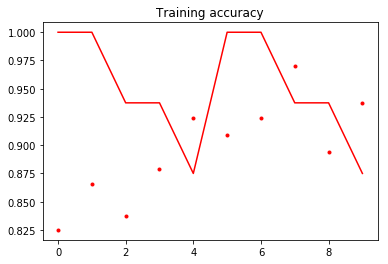

<Figure size 432x288 with 0 Axes>

In [56]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

### Calculate model metrics

In [57]:
eval_preds = model.evaluate_generator(test_gen, steps=test_df.shape[0])
print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eval_preds[0], eval_preds[1]))

Loss: 0.27, Accuracy: 0.92


## Test the model

In [95]:
from tensorflow.keras.preprocessing import image
from numpy import argmax

In [96]:
from IPython.display import Image, display
def predict_bird_from_file(fn, verbose=True):
    img = image.load_img(fn, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x = preprocess_input(x)
    
    results = model.predict(x)
    predicted_class_idx = argmax(results)
    predicted_class = class_name_list[predicted_class_idx]
    confidence = results[0][predicted_class_idx]
    if verbose:
        display(Image(fn))
        print('Class: {}, confidence: {:.2f}'.format(predicted_class, confidence))
    del img, x
    return predicted_class_idx, confidence

In [93]:
from PIL import Image
import io

def predict_bird_from_file2(fn, verbose=True):
    with open(fn, 'rb') as img:
        f = img.read()
    img_as_bytes = bytes(f)
    img = Image.open(io.BytesIO(img_as_bytes))
    img = img.resize((WIDTH, HEIGHT))
    x = np.asarray(img)
    x = x.reshape((1,) + x.shape)

    x = preprocess_input(x)

    print('calling predict...')
    results = model.predict(x)
    predicted_class_idx = argmax(results)
    predicted_class = class_name_list[predicted_class_idx]
    confidence = results[0][predicted_class_idx]
    
    if verbose:
#        display(Image(fn))
        print('Class: {}, confidence: {:.2f}'.format(predicted_class, confidence))

    del img, x

    return predicted_class_idx, confidence

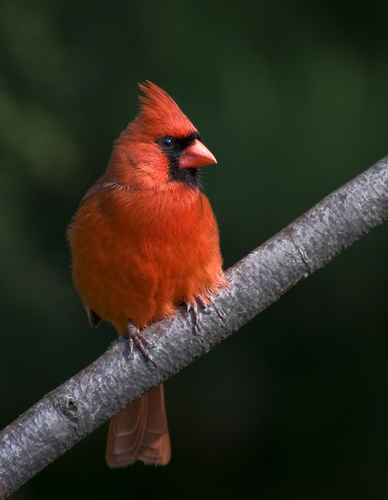

Class: 017.Cardinal, confidence: 1.00


(1, 1.0)

In [97]:
fname = IMAGES_DIR + '/' + test_df.iloc[0]['image_file_name']
#predict_bird_from_file2(fname)
predict_bird_from_file(fname)

### First take a look at how well the model performs against the validation dataset

In [29]:
i = 0
predictions = []
labels = []

val_gen.reset()

for inputs_batch, labels_batch in val_gen:
    preds = model.predict(inputs_batch)
    
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = preds
    labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch

    i += 1
    if i * BATCH_SIZE > num_val_images:
        break
        
print('predicted {} batches of size {} for total of {} images'.format(i - 1, BATCH_SIZE, (i - 1) * BATCH_SIZE))

predicted 1 batches of size 16 for total of 16 images


In [30]:
import numpy as np
predicted_classes = np.zeros(len(predictions), dtype=int)
actual_classes    = np.zeros(len(predictions), dtype=int)
for i in range(len(predictions)):
    predicted_classes[i] = predictions[i].argmax(axis=-1)
    actual_classes[i]    = argmax(labels[i])
predicted_classes = predicted_classes.tolist()
actual_classes    = actual_classes.tolist()

In [31]:
errors = np.where(np.asarray(predicted_classes) != np.asarray(actual_classes))[0]
print('Encountered {} incorrect predictions: {}'.format(len(errors), errors))

Encountered 2 incorrect predictions: [ 2 14]


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.figure(figsize=(7,7))
    plt.grid(False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.gca().set_xticklabels(class_name_list)
    plt.gca().set_yticklabels(class_name_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
from sklearn.metrics import confusion_matrix
def create_and_plot_confusion_matrix(actual, predicted):
    cnf_matrix = confusion_matrix(actual, np.asarray(predicted),labels=range(len(class_name_list)))
    plot_confusion_matrix(cnf_matrix, classes=range(len(class_name_list)))

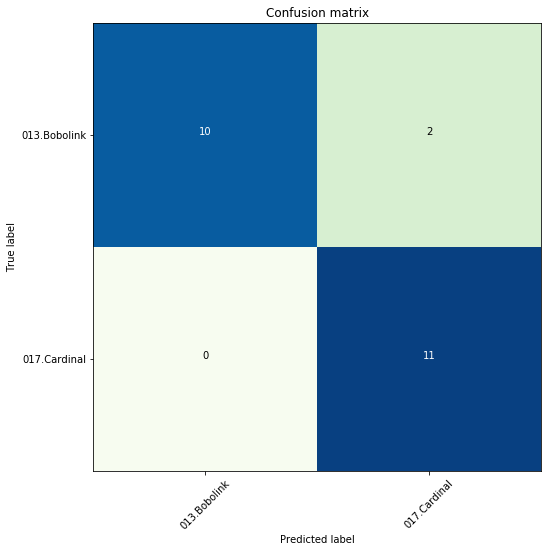

In [34]:
create_and_plot_confusion_matrix(actual_classes, predicted_classes)

### Assess prediction performance against validation and test datasets

In [35]:
from IPython.display import Image, display

# Iterate through entire dataframe, tracking predictions and accuracy. For mistakes, show the image, and the predicted and actual classes to help understand
# where the model may need additional tuning.

def test_image_df(df):
    print('Testing {} images'.format(df.shape[0]))
    num_errors = 0
    preds = []
    acts  = []
    for i in range(df.shape[0]):
        fname = df.iloc[i]['image_file_name']
        act   = int(df.iloc[i]['class_id']) - 1
        acts.append(act)
        pred, conf = predict_bird_from_file(IMAGES_DIR + '/' + fname, verbose=False)
        preds.append(pred)
        if (pred != act):
            num_errors += 1
            print('ERROR on image index {} -- Pred: {} {:.2f}, Actual: {}'.format(i, 
                                                                   class_name_list[pred], conf, 
                                                                   class_name_list[act]))
            display(Image(filename=IMAGES_DIR + '/' + fname))
    return num_errors, preds, acts

In [36]:
num_images = val_df.shape[0]
num_errors, preds, acts = test_image_df(val_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

Testing 23 images

Accuracy: 1.00, 23/23


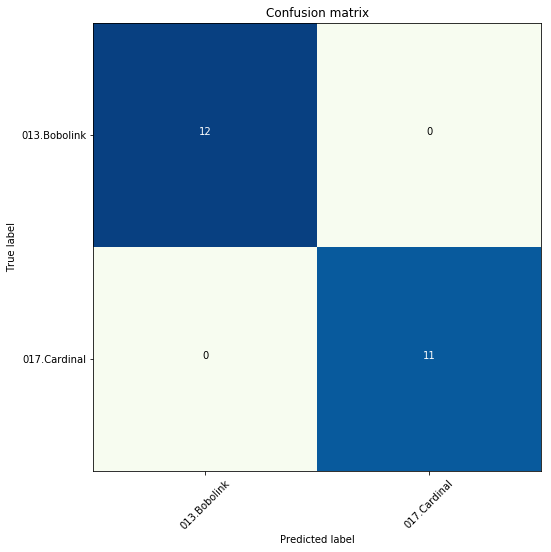

In [37]:
create_and_plot_confusion_matrix(acts, preds)

In [38]:
num_images = test_df.shape[0]
num_errors, preds, acts = test_image_df(test_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

Testing 12 images

Accuracy: 1.00, 12/12


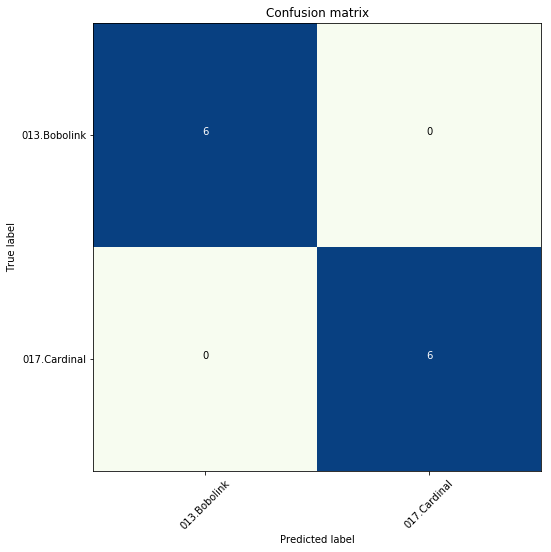

In [39]:
create_and_plot_confusion_matrix(acts, preds)

### Alternatively use the Keras predict_generator for dataset evaluation
Is convenient, but doesn't easily give access to the prediction mistakes.

In [40]:
test_gen.reset()
test_preds = model.predict_generator(test_gen, steps=test_df.shape[0], verbose=0)

In [41]:
preds = np.argmax(test_preds, axis=1)
acts  = np.asarray(test_gen.classes)

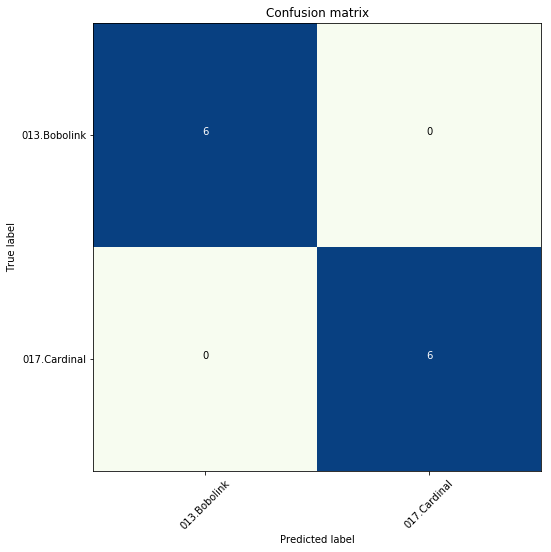

In [42]:
create_and_plot_confusion_matrix(acts, preds)

### Test model against previously unseen images
Here we download images that the algorithm has not yet seen.

In [43]:
!wget -q -O northern-flicker-1.jpg https://upload.wikimedia.org/wikipedia/commons/5/5c/Northern_Flicker_%28Red-shafted%29.jpg
!wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
!wget -q -O blue-jay-1.jpg https://cdn12.picryl.com/photo/2016/12/31/blue-jay-bird-feather-animals-b8ee04-1024.jpg
!wget -q -O blue-jay-2.jpg https://www.pennington.com/-/media/Images/Pennington-NA/US/blog/Wild-Bird/Blue-Jays/Blue-Jay-Eating-Peanuts.jpg
!wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg
!wget -q -O northern-cardinal-2.jpg https://www.allaboutbirds.org/guide/assets/photo/63667291-480px.jpg
!wget -q -O american-goldfinch-1.jpg https://download.ams.birds.cornell.edu/api/v1/asset/59574291/medium
!wget -q -O purple-finch-1.jpg https://indianaaudubon.org/wp-content/uploads/2016/04/PurpleFinchRyanSanderson-e1463792335814.jpg
!wget -q -O purple-finch-2.jpg https://www.singing-wings-aviary.com/wp-content/uploads/2018/06/Purple-Finch.jpg
!wget -q -O mallard-1.jpg https://www.herefordshirewt.org/sites/default/files/styles/node_hero_default/public/2018-01/Mallard%20%C2%A9%20Mark%20Hamblin.jpg

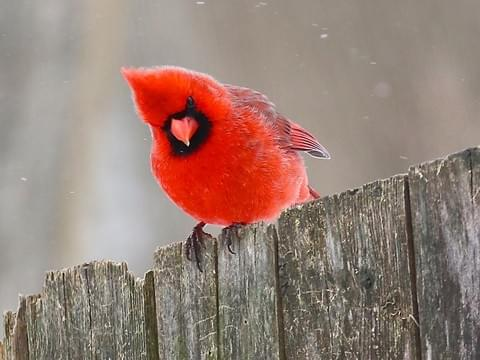

Class: 017.Cardinal, confidence: 1.00


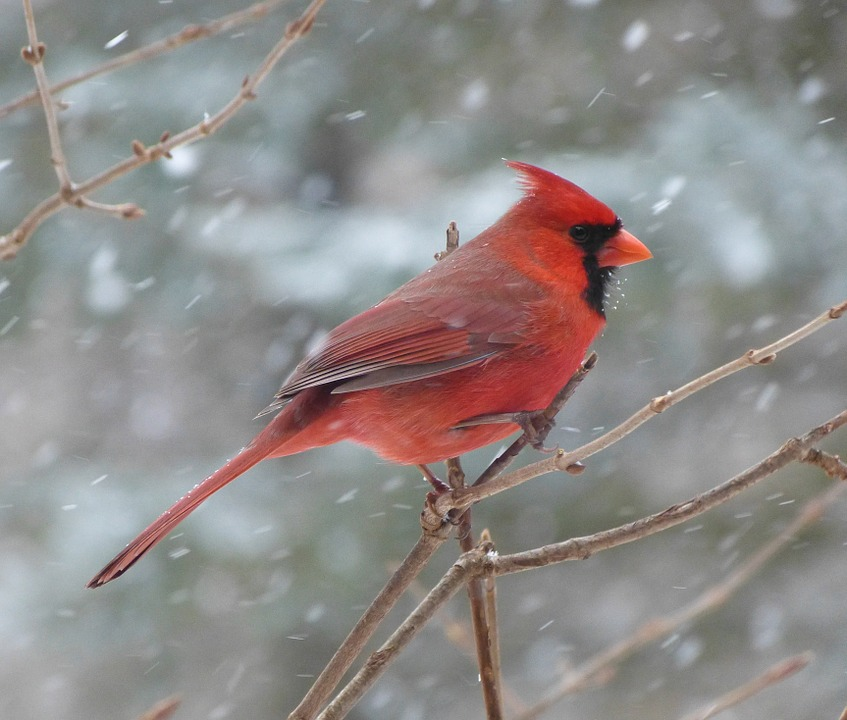

Class: 017.Cardinal, confidence: 1.00


(1, 1.0)

In [44]:
predict_bird_from_file('northern-cardinal-2.jpg')
predict_bird_from_file('northern-cardinal-1.jpg')